Add gain method to CrystalSlice class that applies Frantz-Nodvik equation: issue #137
https://github.com/radiasoft/rslaser/issues/137


_________________
Imports

In [1]:
import sys, time
import math
import numpy as np
from pykern import pkcli
from pykern.pkcollections import PKDict

# The rslaser library may not be installed, so a check is required.
try:
    import rslaser
except:
    # Developers should use 'pip install -e .' from the command line.
    # Users can install directly from GitHub --
    !{sys.executable} -m pip install git+https://github.com/radiasoft/rslaser.git
    import rslaser

from rslaser.pulse import pulse
from rslaser.optics import element
from rslaser.optics import drift
from rslaser.optics import crystal

import scipy.constants as const

import srwlib
from srwlib import srwl

# 2D plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

# reset the notebook style
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

______________
Set laser defaults

In [2]:
# specify parameters
_LASER_PULSE_DEFAULTS = PKDict(
        photon_e_ev=1.5498, # Photon energy [eV], calculated from 800nm wavelength
        nslice = 1,
        nx_slice = 32,
        ny_slice = 32,
)

# Instantiate the default parameters
params = _LASER_PULSE_DEFAULTS.copy()

______________
Define a simple lattice

In [3]:
# instantiate a drift
L_drift = 0.50  # [m]
e_drift = drift.Drift(L_drift)

# instantiate the crystal
crystal_params = PKDict(length = 2.5/100.0,  # [m]
                        nslice = 1,
                        )

______________
Propagate and calculate

Text(0.5, 1.0, 'wfr abs efield')

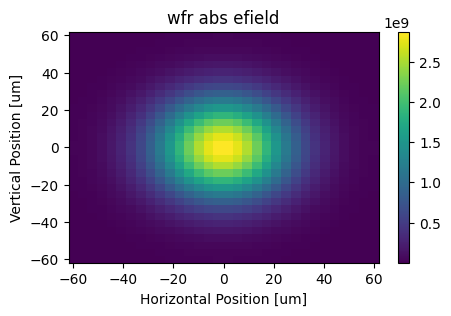

In [4]:
# Initialize crystal and laser pulse
e_crystal = crystal.Crystal(crystal_params)
thisPulse = pulse.LaserPulse(params)

# First drift
thisPulse = e_drift.propagate(thisPulse, 'default')

# Plot wavefront
lp_wfr_x = np.linspace(thisPulse.slice[0].wfr.mesh.xStart,thisPulse.slice[0].wfr.mesh.xFin,thisPulse.slice[0].wfr.mesh.nx)
lp_wfr_y = np.linspace(thisPulse.slice[0].wfr.mesh.yStart,thisPulse.slice[0].wfr.mesh.yFin,thisPulse.slice[0].wfr.mesh.ny)

intensity0 = srwlib.array('f', [0]*thisPulse.slice[0].wfr.mesh.nx*thisPulse.slice[0].wfr.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(intensity0, thisPulse.slice[0].wfr, 0, 0, 3, thisPulse.slice[0].wfr.mesh.eStart, 0, 0) #extracts intensity
intens_2d_0 = np.array(intensity0).reshape((thisPulse.slice[0].wfr.mesh.nx, thisPulse.slice[0].wfr.mesh.ny), order='C') #reshaping
efield_abs_2d = np.sqrt(np.sqrt(const.mu_0 / const.epsilon_0) * 2.0 * intens_2d_0) # [V/m]

fig = plt.figure(figsize=(5,3))
ax = fig.gca()
plt.pcolormesh(lp_wfr_x*1e6, lp_wfr_y*1e6, efield_abs_2d, cmap=plt.cm.viridis,shading='auto')#,vmin=0.95,vmax=1.05)
plt.colorbar()
ax.set_ylabel(r'Vertical Position [um]')
ax.set_xlabel(r'Horizontal Position [um]')
ax.set_title('wfr abs efield')


Text(0.5, 1.0, 'Temp Density Mesh')

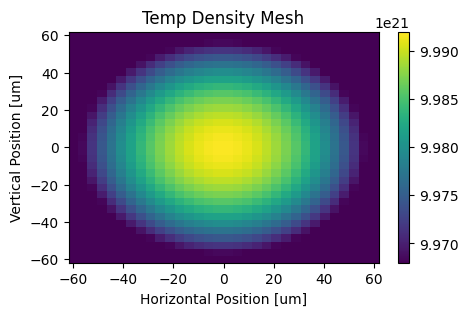

In [5]:
temp_mesh = e_crystal.slice[0]._interpolate_pop_inversion(thisPulse.slice[0].wfr)

# plot the excited state density
fig = plt.figure(figsize=(5,3))
ax = fig.gca()
plt.pcolormesh(lp_wfr_x*1e6, lp_wfr_y*1e6, temp_mesh, cmap=plt.cm.viridis,shading='auto',vmin=9.968e21, vmax=9.992e21)
plt.colorbar()
ax.set_ylabel(r'Vertical Position [um]')
ax.set_xlabel(r'Horizontal Position [um]')
ax.set_title('Temp Density Mesh')


In [10]:
# Calc gain here for comparison with implemented method
cslice_length = e_crystal.slice[0].length            # [m]
absorp_cross_sec = 2.0e-24                           # [m^2] (2.0e-20 cm^2)
degen_factor = 1.0                                   # Not sure what this value should be

wfr0 = thisPulse.slice[0].wfr
dx = (wfr0.mesh.xFin - wfr0.mesh.xStart)/wfr0.mesh.nx
dy = (wfr0.mesh.yFin - wfr0.mesh.yStart)/wfr0.mesh.ny

# total number of incident photons per unit area
n_incident_photons = thisPulse.slice[0].n_photons_2d / (dx * dy)   # [1/m^2]
print('Total number initially: ', np.sum(np.sum(thisPulse.slice[0].n_photons_2d)))

# energy_gain = (1.0 / (degen_factor * absorp_cross_sec * n_incident_photons)) * \
#                 np.log(1 + np.exp(absorp_cross_sec * temp_mesh * cslice_length) * \
#                 (np.exp(degen_factor * absorp_cross_sec * n_incident_photons) - 1.0))

# # Update the number of photons
# new_n_photons = thisPulse.slice[0].n_photons_2d * energy_gain
# print('Total number after gain: ', np.sum(np.sum(new_n_photons)))

# # Update the pop_inversion
# print(np.max(temp_mesh))
# print(np.max(temp_mesh - (degen_factor * n_incident_photons * (energy_gain - 1.0) / cslice_length)))

# # # Through crystal (1 slice for now)
# # thisPulse = e_crystal.propagate(thisPulse, 'gain_test') #'n0n2_srw')

# # # PRINT CHANGE FROM THIS GUY

# # # Last drift
# # thisPulse = e_drift.propagate(thisPulse, 'default')


Total number initially:  2.8043227e+16
0.000499593481157304


/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  
